In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Group project /data_20240208.csv')

Mounted at /content/drive


# data discovery

In [ ]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15372 entries, 0 to 15371
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   unique_id       15372 non-null  object
 1   Title           15372 non-null  object
 2   Description     15372 non-null  object
 3   AdditionalInfo  1857 non-null   object
 4   ClosingDate     14634 non-null  object
dtypes: object(5)
memory usage: 600.6+ KB


In [ ]:
# check duplicates
# we can file here that there are no duplicates in All
data.duplicated().sum()

0

In [ ]:
data.head()



,unique_id,Title,Description,AdditionalInfo,ClosingDate
0,62961f0c-33ea-4eae-8f0d-e1a41196a159,Scaffolding Framework,Corserv Ltd on behalf of its group of Companie...,NaN,2/17/23
1,21c4dce0-a6c7-4e5b-bf85-5747722dc8d7,Tray Wrap & Sterilisation Products,This framework agreement for Tray Wrap and Ste...,NaN,3/16/23
2,cca5b2bb-d150-44d1-8e9c-0e496955ccfe,"Cycle Hangars - Supply, Installation & Mainten...","Having secured the necessary funding, the Lond...",NaN,3/16/23
3,6ad9a124-6cd4-4fba-b617-ba1ee44ef72a,RA327582 - Training,If you have any enquiries regarding the work r...,NaN,2/21/23
4,f9c04728-c641-4e4a-8aa1-b1b1a35c7c7f,CDD Screening Solution and Fraud Investigation...,1. Homes England intends to procure a new: i. ...,NaN,2/28/23


In [ ]:
# count unique values in titie
Title_nunique =  data['Title'].nunique()
print("count unique values in titie: ", Title_nunique)

count unique values in titie:  5397


In [ ]:
# # check duplicates in Title
duplicate_num = data.duplicated(subset=['Title']).sum()
print(f'There are {duplicate_num} duplicates in Title')

There are 9975 duplicates in Title


In [ ]:
# # check duplicates in description
duplicate_num = data.duplicated(subset=['Description']).sum()
print(f'There are {duplicate_num} duplicates in Description')

There are 9830 duplicates in Description


In [ ]:
# check duplicates in both Title and description columns
duplicate_num = data.duplicated(subset=['Title', 'Description','AdditionalInfo']).sum()
print(f'There are {duplicate_num} duplicates in Title and Description with ratio {duplicate_num/len(data):.2%}')


There are 9354 duplicates in Title and Description with ratio 60.85%


In [ ]:
# print size after dropping duplicates
size_after_drop_duplicates = data.drop_duplicates(subset=['Title', 'Description']).shape[0]
print(f'Size of data after dropping duplicates is {size_after_drop_duplicates} instead of {data.shape[0]}')

Size of data after dropping duplicates is 5640 instead of 15372


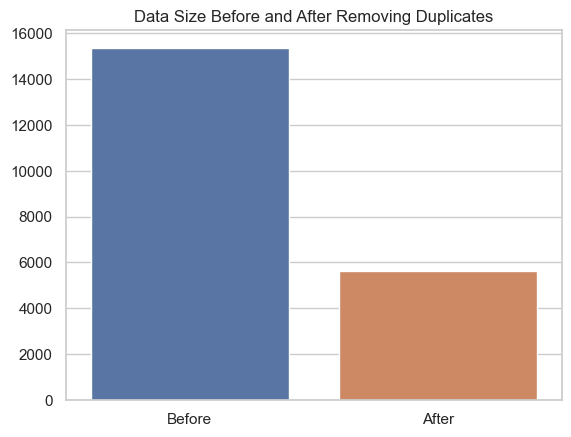

In [ ]:
# plot chart to see size of data before and after removing duplicates using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=['Before', 'After'], y=[data.shape[0], data.drop_duplicates(subset=['Title', 'Description']).shape[0]])
# sns.barplot(x=['Before', 'After'], y=[data.shape[0], data.drop_duplicates(subset=['Title', 'Description']).shape[0]], ax=ax[1])
# ax[1].set(ylim=(0, 1000))
# add title
plt.title('Data Size Before and After Removing Duplicates')
plt.show()




```
# This is formatted as code
```

# preprocessing


In [ ]:
# get copy from data
data_cleaned = data.copy()

## 1) drop duplicates in Title and Description


In [ ]:
data_cleaned.drop_duplicates(subset=['Title', 'Description'], inplace=True)
# reset index
data_cleaned.reset_index(drop=True, inplace=True)


In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   unique_id       5641 non-null   object
 1   Title           5641 non-null   object
 2   Description     5641 non-null   object
 3   AdditionalInfo  1411 non-null   object
 4   ClosingDate     5408 non-null   object
dtypes: object(5)
memory usage: 220.5+ KB


## 2) apply lower case to Title, Description and AdditionalInfo

In [ ]:
# apply lower case to Title and Description
data_cleaned['cleaned_Title'] = data_cleaned['Title'].str.lower()
data_cleaned['cleaned_Description'] = data_cleaned['Description'].str.lower()
data_cleaned['cleaned_AdditionalInfo'] = data_cleaned['AdditionalInfo'].str.lower()

## 3) drop URL form description

In [ ]:
import re

def remove_sentences_with_urls(description):
    # Split the description into sentences
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', description)

    # Remove sentences containing URLs
    cleaned_sentences = [sentence for sentence in sentences if not re.search(r'http\S+', sentence)]

    # Join the cleaned sentences back into a single description
    cleaned_description = ' '.join(cleaned_sentences)

    return cleaned_description.strip()  # Remove leading/trailing whitespaces


# Apply the function to the Description column
data_cleaned['cleaned_Description'] = data_cleaned['cleaned_Description'].apply(remove_sentences_with_urls)


## 3) drop frequent words and stop words from Title and Description

In [ ]:
# count frequency of each word in Title and Description
from collections import Counter
import re

# split Title and Description into words
words_title = data_cleaned['Title'].str.split(expand=True).stack()
words_description = data_cleaned['Description'].str.split(expand=True).stack()
words_additional_info = data_cleaned['AdditionalInfo'].str.split(expand=True).stack()

# count frequency of each word
word_freq_title = Counter(words_title)
word_freq_description = Counter(words_description)
word_freq_additional_info = Counter(words_additional_info)

# convert to dataframe
word_freq_title = pd.DataFrame(word_freq_title.items(), columns=['word', 'frequency'])
word_freq_description = pd.DataFrame(word_freq_description.items(), columns=['word', 'frequency'])
word_freq_additional_info = pd.DataFrame(word_freq_additional_info.items(), columns=['word', 'frequency'])

# sort by frequency
word_freq_title.sort_values('frequency', ascending=False, inplace=True)
word_freq_description.sort_values('frequency', ascending=False, inplace=True)
word_freq_additional_info.sort_values('frequency', ascending=False, inplace=True)

# plot top 10 frequent words in Title and Description



In [ ]:
# title frequency words
word_freq_title.head(15)
word_freq_title.head(10)
# word_freq_additional_info.head(15)

,word,frequency
9,-,1980
18,and,1809
45,of,1422
93,for,1179
53,Services,811
43,the,594
4,&,534
94,Provision,468
56,to,385
105,Service,341


In [ ]:
# drop stop words from Title and Description
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# remove stop words from Title and Description
data_cleaned['cleaned_Title'] = data_cleaned['cleaned_Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data_cleaned['cleaned_Description'] = data_cleaned['cleaned_Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# remove stop words from AdditionalInfo if it is not null
for i in range(len(data_cleaned)):
    if pd.notna(data_cleaned['cleaned_AdditionalInfo'][i]):
        data_cleaned['cleaned_AdditionalInfo'][i] = ' '.join([word for word in data_cleaned['cleaned_AdditionalInfo'][i].split() if word not in (stop_words)])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eslam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4) drop un-important panctuations from Title and Description

In [ ]:
# count frequency of pandctuation in Title and Description
punctuation_title = Counter(re.sub(r'\w', '', ' '.join(data_cleaned['Title'])).split())
punctuation_description = Counter(re.sub(r'\w', '', ' '.join(data_cleaned['Description'])).split())
punctuation_additional_info = Counter(re.sub(r'\w', '', ' '.join(data_cleaned[data_cleaned['AdditionalInfo'].notna()]['AdditionalInfo'])).split())

# convert to dataframe
punctuation_title = pd.DataFrame(punctuation_title.items(), columns=['punctuation', 'frequency'])
punctuation_description = pd.DataFrame(punctuation_description.items(), columns=['punctuation', 'frequency'])
punctuation_additional_info = pd.DataFrame(punctuation_additional_info.items(), columns=['punctuation', 'frequency'])

# sort by frequency
punctuation_title.sort_values('frequency', ascending=False, inplace=True)
punctuation_description.sort_values('frequency', ascending=False, inplace=True)
punctuation_additional_info.sort_values('frequency', ascending=False, inplace=True)

# plot top 10 frequent punctuation in Title and Description
punctuation_title.head(10)
punctuation_description.head(10)#.iloc[0,1]
# punctuation_additional_info.head(10)

,punctuation,frequency
0,.,46445
1,",",42716
2,-,16171
4,:,9458
15,(,5530
3,(),5170
17,',4626
16,),4148
28,‚¢,3475
10,/,2541


In [ ]:
# remove punctuation from Title and Description
import string
panctuation = string.punctuation
# !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
print(panctuation)
panctuation = panctuation + 'ä' +'®' + '≥' +'»' + '˚'+'€' + '±'+ '¥' +'•' + '±' + '£' + '’' + '‘' + '–' + '➢' + '·' + '–' + '“”' + '™' + '°' + '' + '”' + '“' + '' + '' + '≤' + ''
# panctuation = panctuation +
print(panctuation)

data_cleaned['cleaned_Title'] = data_cleaned['cleaned_Title'].apply(lambda x: x.translate(str.maketrans('', '', panctuation)))
data_cleaned['cleaned_Description'] = data_cleaned['cleaned_Description'].apply(lambda x: x.translate(str.maketrans('', '', panctuation)))
# remove punctuation from AdditionalInfo if it is not null
for i in range(len(data_cleaned)):
    if pd.notna(data_cleaned['cleaned_AdditionalInfo'][i]):
        data_cleaned['cleaned_AdditionalInfo'][i] = data_cleaned['cleaned_AdditionalInfo'][i].translate(str.maketrans('', '', panctuation))

# count frequency of each word in Title and Description after removing stop words


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ä®≥»˚€±¥•±£’‘–➢·–“”™°”“≤


## 5) job code

In [ ]:
# remove job code from Title and Description
# code that contains letters and numbers or numbers more than 3 digits
regex_formula = r'\b[a-zA-Z]+\d+|\d+[a-zA-Z]+\d+|\d+[a-zA-Z]+\b|\b\d{4,}\b'
data_cleaned['cleaned_Title'] = data_cleaned['cleaned_Title'].apply(lambda x: re.sub(regex_formula, '', x))
data_cleaned['cleaned_Description'] = data_cleaned['cleaned_Description'].apply(lambda x: re.sub(regex_formula, '', x))
# remove job code from AdditionalInfo if it is not null
for i in range(len(data_cleaned)):
    if pd.notna(data_cleaned['cleaned_AdditionalInfo'][i]):
        data_cleaned['cleaned_AdditionalInfo'][i] = re.sub(regex_formula, '', data_cleaned['cleaned_AdditionalInfo'][i])


## 6) drop extra spaces from Title and Description

In [ ]:
# replace extra spaces with single space
data_cleaned['cleaned_Title'] = data_cleaned['cleaned_Title'].str.replace(r'\s+', ' ')
data_cleaned['cleaned_Description'] = data_cleaned['cleaned_Description'].str.replace(r'\s+', ' ')
# replace extra spaces with single space in AdditionalInfo if it is not null
for i in range(len(data_cleaned)):
    if pd.notna(data_cleaned['cleaned_AdditionalInfo'][i]):
        data_cleaned['cleaned_AdditionalInfo'][i] = re.sub(r'\s+', ' ', data_cleaned['cleaned_AdditionalInfo'][i])

# remove leading and trailing whitespaces
data_cleaned['cleaned_Title'] = data_cleaned['cleaned_Title'].str.strip()
data_cleaned['cleaned_Description'] = data_cleaned['cleaned_Description'].str.strip()
# remove leading and trailing whitespaces in AdditionalInfo if it is not null
for i in range(len(data_cleaned)):
    if pd.notna(data_cleaned['cleaned_AdditionalInfo'][i]):
        data_cleaned['cleaned_AdditionalInfo'][i] = data_cleaned['cleaned_AdditionalInfo'][i].strip()


# save the data to a new file

In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   unique_id               5641 non-null   object
 1   Title                   5641 non-null   object
 2   Description             5641 non-null   object
 3   AdditionalInfo          1411 non-null   object
 4   ClosingDate             5408 non-null   object
 5   cleaned_Title           5641 non-null   object
 6   cleaned_Description     5641 non-null   object
 7   cleaned_AdditionalInfo  1411 non-null   object
dtypes: object(8)
memory usage: 352.7+ KB


In [ ]:
# convert empty string to NaN
data_cleaned['cleaned_Title'].replace('', np.nan, inplace=True)
data_cleaned['cleaned_Description'].replace('', np.nan, inplace=True)


In [ ]:
# drop miss values in Title and Description

data_cleaned.dropna(subset=['cleaned_Title', 'cleaned_Description'], inplace=True)
data_cleaned.info()

data_cleaned.to_csv('DataProj\data_cleaned.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 5622 entries, 0 to 5640
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   unique_id               5622 non-null   object
 1   Title                   5622 non-null   object
 2   Description             5622 non-null   object
 3   AdditionalInfo          1406 non-null   object
 4   ClosingDate             5389 non-null   object
 5   cleaned_Title           5622 non-null   object
 6   cleaned_Description     5622 non-null   object
 7   cleaned_AdditionalInfo  1406 non-null   object
dtypes: object(8)
memory usage: 395.3+ KB


# plot

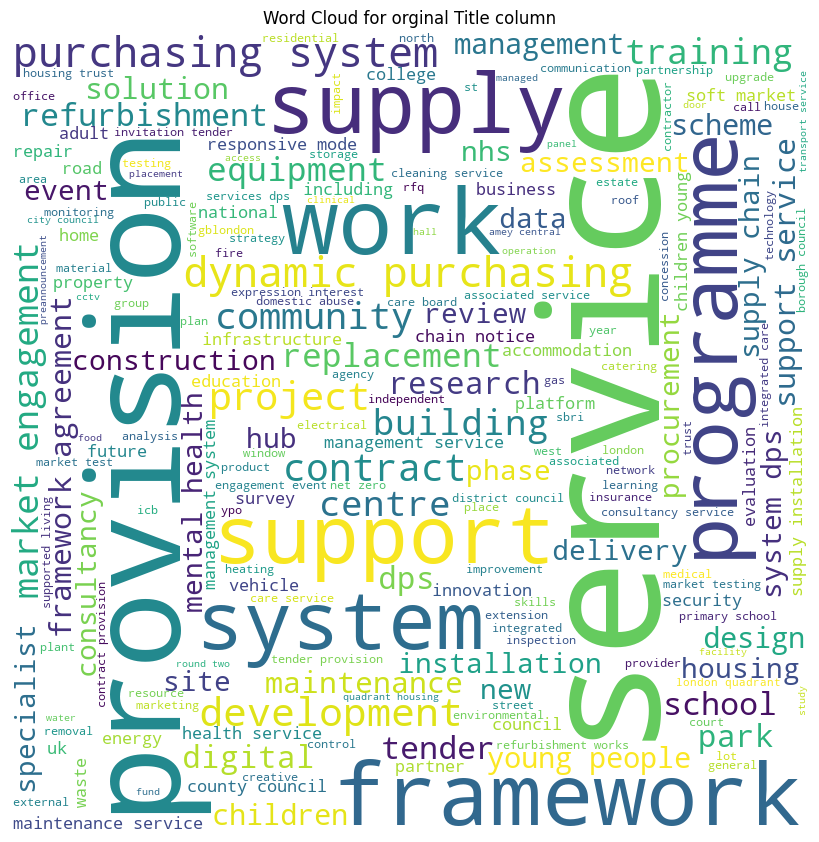

In [ ]:
# count frequency of word in Title
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# check frequency chart in Title and Description

# check frequency word in all Title text
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(data_cleaned['cleaned_Title']))

plt.figure(figsize = (8, 8), facecolor = None)

plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud for orginal Title column')
plt.grid(False)


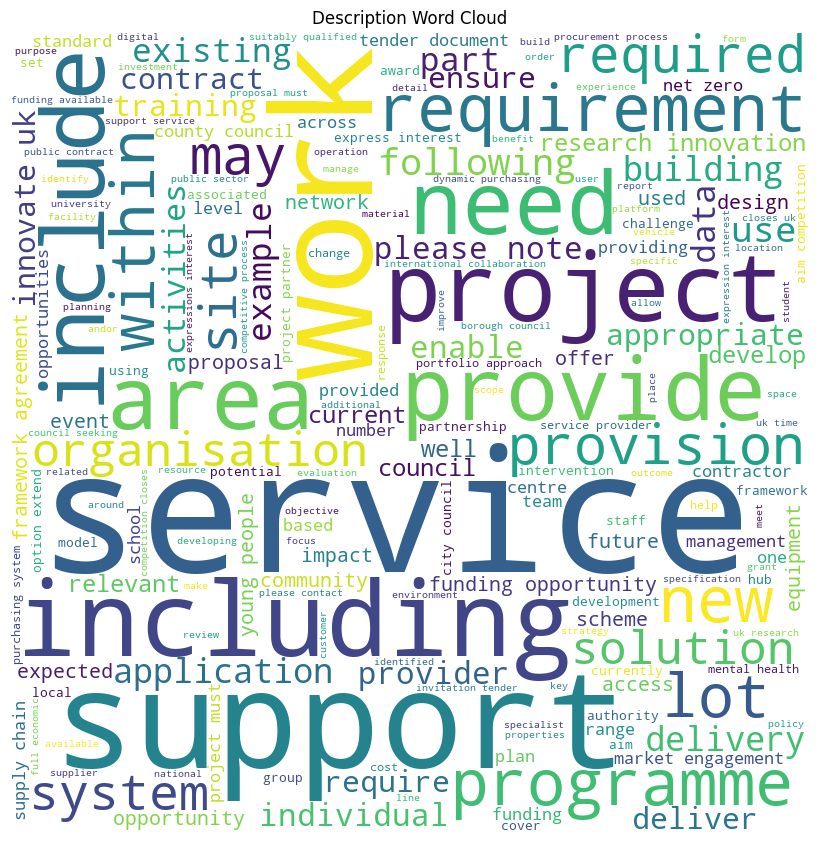

In [ ]:
# count frequency of word in Title
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# check frequency chart in Title and Description

# check frequency word in all Title text
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(data_cleaned['cleaned_Description']))

plt.figure(figsize = (8, 8), facecolor = None)

plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Description Word Cloud')
plt.grid(False)


# search on data

In [ ]:
clean_data = pd.read_csv('DataProj\data_cleaned.csv')

In [ ]:
# apply lower case on title and description
data['Title'] = data['Title'].str.lower()
data['Description'] = data['Description'].str.lower()
clean_data['Title'] = clean_data['Title'].str.lower()
clean_data['Description'] = clean_data['Description'].str.lower()

# search for specific word in Title and Description
frst_word_search_word = 'Strategy' # s, process and manufacturing design technologies
frst_word_search_word = frst_word_search_word.lower()
# f1 = data[data['Title'].str.contains(frst_word_search_word) | data['Description'].str.contains(frst_word_search_word)]#.shape
f1 = clean_data[clean_data['cleaned_Title'].str.contains(frst_word_search_word) | clean_data['cleaned_Description'].str.contains(frst_word_search_word)]#.shape
# f1 = clean_data[clean_data['Title'].str.contains(frst_word_search_word) | clean_data['Description'].str.contains(frst_word_search_word)]#.shape

# Ceramic / electronic / functional materials


f1.shape
print(f1.shape)
second_word_search_word = 'manufacturing' #   , medical technology and devices
second_word_search_word = second_word_search_word.lower()
f2 = clean_data[clean_data['cleaned_Title'].str.contains(second_word_search_word) | clean_data['cleaned_Description'].str.contains(second_word_search_word)]#.shape
print(f2.shape)
# get rows that has both words on same title or description
f3 = clean_data[(clean_data['cleaned_Description'].str.contains(frst_word_search_word)) & (clean_data['cleaned_Description'].str.contains(second_word_search_word))]#.shape
print(f3.shape)
# # get both results
f1_f2 = pd.concat([f1, f2]).drop_duplicates()
f1_f2.shape
f1_f2['unique_id'].nunique()

(362, 8)
(171, 8)
(45, 8)


488